In [5]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns

from matplotlib import image
from sklearn.metrics import confusion_matrix
#from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names)
    test_df = pd.read_csv(data_folder + test_file, names = column_names)
    
    return training_df, validation_df, test_df

In [7]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

In [8]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")


Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


In [9]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data
training_generator = ImageDataGenerator(rescale=rescaling_factor) # You can add parameters if you wanna
# do data augmentation.
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width = 64
image_height = 64

batch_size = 128 # How big of a set of data to use for every training epoch


In [10]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


## Some data inspection

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


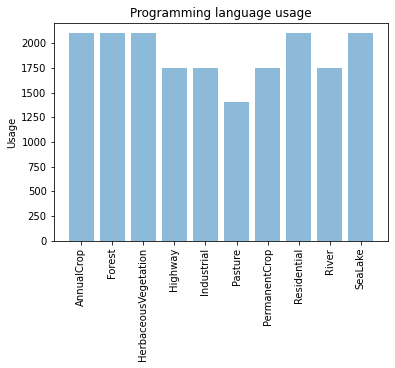

In [11]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

objects = class_name_list
y_pos = np.arange(len(objects))
n_images = count

plt.bar(y_pos, n_images, align='center', alpha=0.5)
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

### Plot an image for each class for visual inspection

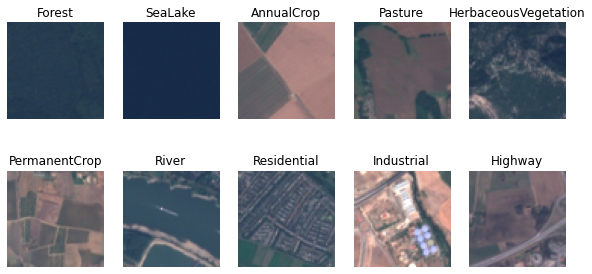

In [12]:
figure_height = 2
figure_width = 5
figure_size = (10, 5)

images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
already_used_labels = []

imgs_to_plot = []
labels_to_plot = []

# Pick an image for each category from the training test:

while len(imgs_to_plot) < 9:
    for idx in range(len(images)):
        if class_name_list[class_ids[idx].astype(bool)][0] in already_used_labels:
            pass
        else:
            imgs_to_plot.append(images[idx])
            labels_to_plot.append(class_name_list[class_ids[idx].astype(bool)][0])
            already_used_labels.append(class_name_list[class_ids[idx].astype(bool)][0])

for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(imgs_to_plot[index])
    plt.title(labels_to_plot[index])
    plt.axis("off")

# CNNs

## VGG16
Use pre-trained weight as they work better than randomly initializing them.
**You can experiment with that as well.**

In [13]:
base_vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
base_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

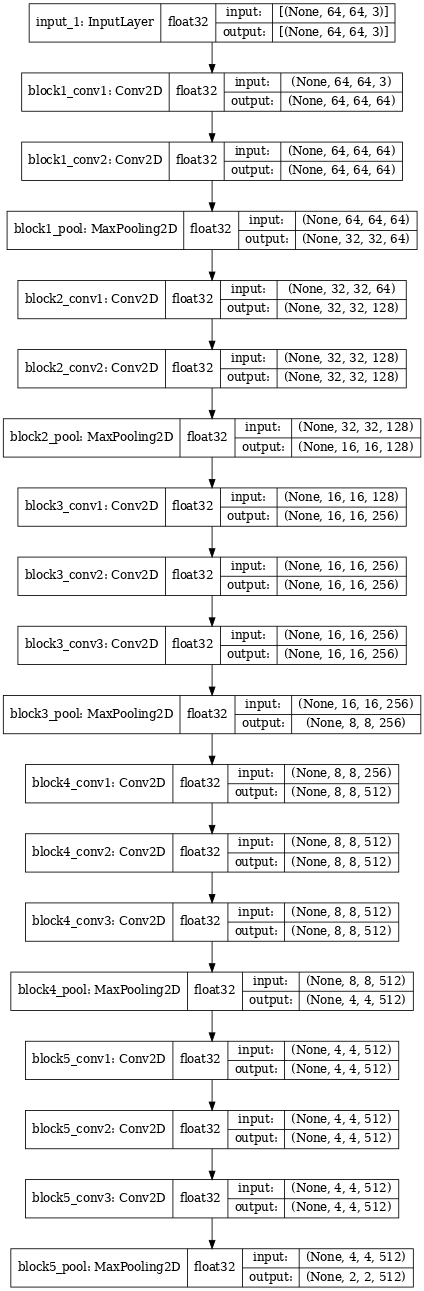

In [14]:
tf.keras.utils.plot_model(
    base_vgg16,
    to_file="vgg16_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=60, # increase for bigger size image
)

## Add custom layers to VGG16
From https://www.kaggle.com/code/rnogueras/keras-basic-toolbox-for-image-recognition/notebook:

Next I will define the final layers of the architecture. I will use a 
- **dropout layer** to prevent overfitting of the convolutional base
- a **He normal initializer** for the weights of the dense layer
- a **Softmax function** to produce the multiclass output.

**todo: change this, and find your own layers for training**

In [15]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


Callbacks
I will also define some callbacks: Checkpoint will save the weights of the best model, ReduceLROnPleateau will accelerate the transit of the gradient through the plains of the cost function and EarlyStopping will end the training if the loss function does not improve in 15 epochs.

In [16]:
model_path = "/kaggle/working/models/eurosat_rgb_vgg16_model.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [18]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=3,
    verbose=1,
)


Epoch 1/3
148/148 [==============================] - 168s 1s/step - loss: 0.6153 - accuracy: 0.7939 - val_loss: 0.2322 - val_accuracy: 0.9270
Epoch 2/3
148/148 [==============================] - 38s 257ms/step - loss: 0.2161 - accuracy: 0.9325 - val_loss: 0.1786 - val_accuracy: 0.9443
Epoch 3/3
148/148 [==============================] - 41s 273ms/step - loss: 0.1473 - accuracy: 0.9522 - val_loss: 0.1533 - val_accuracy: 0.9493


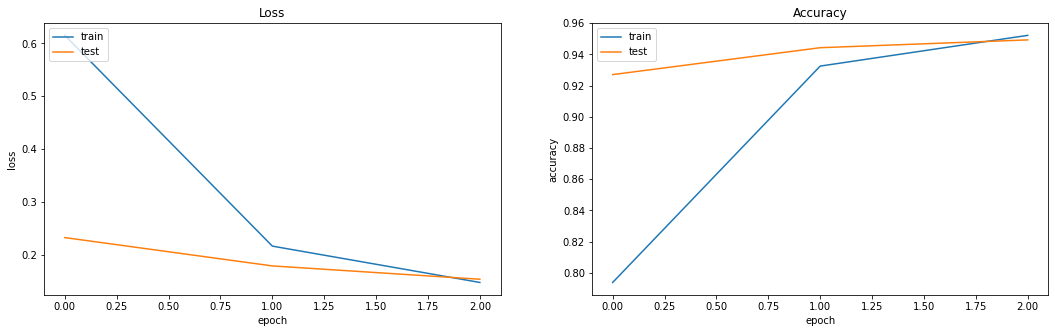

In [19]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

There is a bit of a gap between training and testing.
Try to explore and experiment on why.



# Evaluate Model

In [20]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 18s 864ms/step - loss: 0.1296 - accuracy: 0.9596


# Predict Test Set

In [21]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 5s 2ms/step


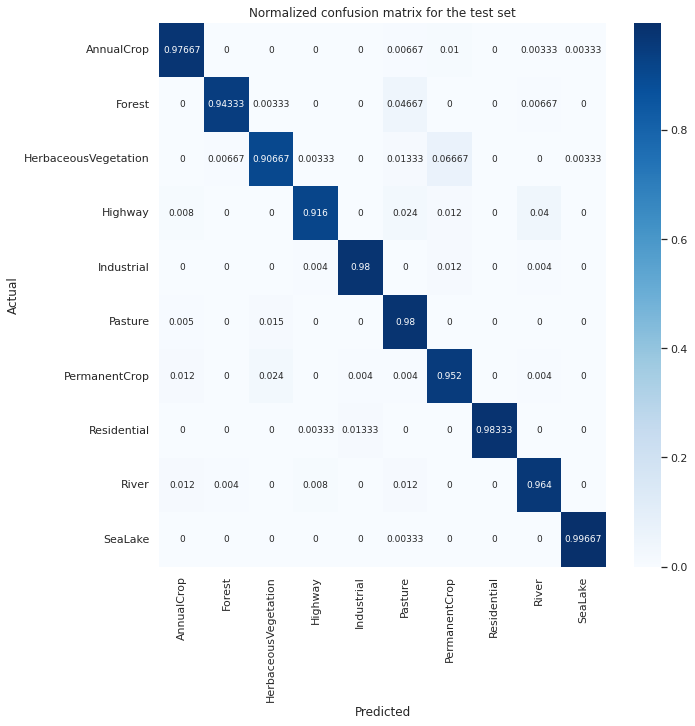

In [32]:
cm = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = cmn.round(5)
confusion_matrix_df = pd.DataFrame(
    data=cmn, 
    index=class_name_list, 
    columns=class_name_list
)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized confusion matrix for the test set')
plt.show(block=False)


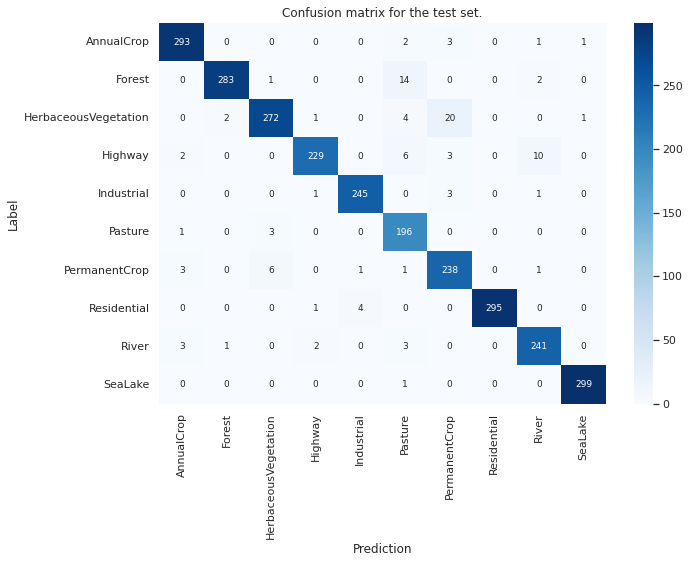

In [31]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()

In [24]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)


Plot wrong predictions

In [25]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

109 wrong predictions out of 2700


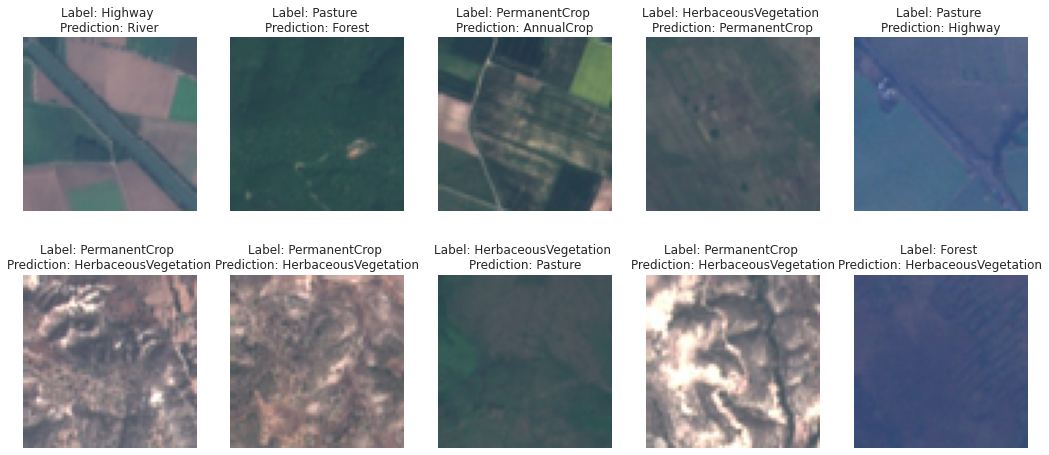

In [36]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_size = (18, 8)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")